# Vertex performance assessment

This notebook processes the output of the <code>VertexMonitoringAlgorithm</code> to allow comparison of the vertexing performance of different vertexing implementations.

The setup for this assessment allows for the comparison of either two or three samples (this can be helpful for looking at the performance of individual passes of the vertexing network), but it should be fairly clear how to adapt the functions to  present a single case without a reference.

The original implementation of this notebook assumed a comparison between the Pandora vertexing BDT and the newer Pandora deep-learning approach, and as such, the plot labels typically refer to 'Pandora' as the referenece BDT version, and 'Pandora DL' as the deep-learning version, with pass 1 and pass 2 suffixes as appropriate.

Hopefully the individual function names are fairly self-explanatory given that context. The cells up until the 'Two sample comparisons' can be run in order, possibly after updating labels to suit the current use case.

After this, you can run either the two or three sample sections after updating the input file locations and the output filename prefixes as appropriate.

The statistics of interest in these sections are the 'drXY' values, which indicate the maximum distance between the reconstructed and true vertice at which XY% of all event are covered, and then the '% < Xcm' value, which indicate what fraction of events have vertices within a given distance of the true vertex. Finally, these sections produce plots showing the distributions of dr, dx, dy and dz.

In [1]:
import uproot, numpy as np

In [2]:
def load_file(filename, treename):
    file = uproot.open(filename)
    tree = file[treename]
    successes = tree['success'].array(library="np")
    true_nu_energy = tree['trueNuEnergy'].array(library="np")
    drs = tree['dr'].array(library="np")
    dxs = tree['dx'].array(library="np")
    dys = tree['dy'].array(library="np")
    dzs = tree['dz'].array(library="np")
    passing_idx = np.where(successes == 1)
    file.close()
    return drs, dxs, dys, dzs, passing_idx, true_nu_energy

In [3]:
import os

def save_plot(fig, filename, subdir=None):
    if subdir is None:
        subdir = ""
    elif subdir.startswith("/"):
        subdir = subdir[1:]
        
    if not os.path.exists('images'):
        os.mkdir('images')
    for img_type in [ "png", "svg", "eps", "pdf" ]:
        if not os.path.exists(f'images/{img_type}'):
            os.mkdir(f'images/{img_type}')
        if not os.path.exists(f'images/{img_type}/{subdir}'):
            os.mkdir(f'images/{img_type}/{subdir}')
        fig.savefig(f'images/{img_type}/{subdir}/{filename}.{img_type}', dpi=200, facecolor='w')

In [4]:
labelsize=14
titlesize=18

import matplotlib.pyplot as plt
import matplotlib.ticker as tck

def plot_dr(drs1, drs2, file_prefix):
    fig, ax = plt.subplots(figsize=(12,8))
    
    bins = np.logspace(-2, 7, 10, base=3)
    weights1 = np.ones_like(drs1) / len(drs1)
    ax.hist(drs1, bins=bins, weights=weights1, histtype='step', lw=2, label="Pandora Ref")
    weights2 = np.ones_like(drs2) / len(drs2)
    ax.hist(drs2, bins=bins, weights=weights2, histtype='step', lw=2, label="Pandora New")
    
    ax.set_title("3D vertex reconstruction", fontsize=titlesize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.set_xlabel("reco - true (cm)", fontsize=titlesize)
    ax.set_ylabel("f", fontsize=titlesize)
    ax.set_xscale('log')
    ax.set_xticks(bins)
    ax.get_xaxis().set_major_formatter(tck.LogFormatter(base=3))
    ax.legend(fontsize=titlesize)

    fig.tight_layout()
    plt.show()
    save_plot(fig, f'{file_prefix}')
    
    
def plot_dr_zoom(drs1, drs2, file_prefix):
    fig, ax = plt.subplots(figsize=(12,8))
    
    bins = np.linspace(0, 10, 20)
    weights1 = np.ones_like(drs1) / len(drs1)
    ax.hist(drs1, bins=bins, weights=weights1, histtype='step', lw=2, label="Pandora Ref")
    weights2 = np.ones_like(drs2) / len(drs2)
    ax.hist(drs2, bins=bins, weights=weights2, histtype='step', lw=2, label="Pandora New")
    
    ax.set_title("3D vertex reconstruction", fontsize=titlesize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.set_xlabel("reco - true (cm)", fontsize=titlesize)
    ax.set_ylabel("f", fontsize=titlesize)
    ax.legend(fontsize=titlesize)

    # Add a label for the total counts visible and the mean + std.
    visible_1 = np.where((drs1 >= 0) & (drs1 <= 10))
    visible_2 = np.where((drs2 >= 0) & (drs2 <= 10))
    ax.text(0.15, 0.95, f"Ref: {len(visible_1[0])} ({np.mean(drs1[visible_1]):.2f} +/- {np.std(drs1[visible_1]):.2f})",
            transform=ax.transAxes, fontsize=titlesize, verticalalignment='top')
    ax.text(0.15, 0.90, f"New: {len(visible_2[0])} ({np.mean(drs2[visible_2]):.2f} +/- {np.std(drs2[visible_2]):.2f})",
            transform=ax.transAxes, fontsize=titlesize, verticalalignment='top')
    
    fig.tight_layout()
    plt.show()
    save_plot(fig, f'{file_prefix}')


def plot_dx(dxs1, dxs2, file_prefix, axis='x', log=False, hi=2.55, lo=-2.55, nbins=52):
    fig, ax = plt.subplots(figsize=(12,8))

    bins = np.linspace(lo, hi, nbins)
    weights1 = np.ones_like(dxs1) / len(dxs1)
    ax.hist(dxs1, bins=bins, weights=weights1, histtype='step', lw=2, label="Pandora Ref")
    weights2 = np.ones_like(dxs2) / len(dxs2)
    ax.hist(dxs2, bins=bins, weights=weights2, histtype='step', lw=2, label="Pandora New")
    
    ax.set_title(f"Vertex reconstruction (d{axis})", fontsize=titlesize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.set_xlabel("reco - true (cm)", fontsize=titlesize)
    ax.set_ylabel("f", fontsize=titlesize)
    if log:
        ax.set_yscale('log')
    ax.legend(fontsize=titlesize)

    # Add a label for the total counts visible and the mean + std.
    visible_1 = np.where((dxs1 >= lo) & (dxs1 <= hi))
    visible_2 = np.where((dxs2 >= lo) & (dxs2 <= hi))
    ax.text(0.05, 0.95, f"Ref: {len(visible_1[0])} ({np.mean(dxs1[visible_1]):.2f} +/- {np.std(dxs1[visible_1]):.2f})",
            transform=ax.transAxes, fontsize=titlesize, verticalalignment='top')
    ax.text(0.05, 0.90, f"New: {len(visible_2[0])} ({np.mean(dxs2[visible_2]):.2f} +/- {np.std(dxs2[visible_2]):.2f})",
            transform=ax.transAxes, fontsize=titlesize, verticalalignment='top')

    fig.tight_layout()
    plt.show()
    save_plot(fig, f'{file_prefix}')


def plot_energy(energy0, energy1, file_prefix):
    fig, ax = plt.subplots(figsize=(12,8))
    
    bins = np.logspace(-3, 7, 11, base=2)
    ax.hist(energy0, bins=bins, histtype='step', lw=2, label='All events')
    ax.hist(energy1, bins=bins, histtype='step', lw=2, label='Reconstructed events')
    
    ax.set_title("True neutrino energy", fontsize=titlesize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.set_xlabel("energy (GeV)", fontsize=titlesize)
    ax.set_ylabel("f", fontsize=titlesize)
    ax.legend(fontsize=titlesize)
    ax.set_xscale('log')
    ax.set_xticks(bins)
    ax.get_xaxis().set_major_formatter(tck.LogFormatter(base=2))
    
    fig.tight_layout()
    plt.show()
    save_plot(fig, f'{file_prefix}')


def plot_dr_vs_energy(energy, passing, drs0):
    fig, ax = plt.subplots(figsize=(12,8))
    
    bins = np.logspace(-3, 7, 11, base=2)
    print(bins)
    indices_set = [ np.where((energy[passing] >= bins[i]) & (energy[passing] < bins[i + 1]))
                   for i in range(len(bins) - 1) ]
    drs_set = [ drs0[indices] for indices in indices_set ]
    bins_dr = np.logspace(-3, 10, 14, base=2)
    for i, drs in enumerate(drs_set):
        weights = np.ones_like(drs) / len(drs)
        ax.hist(drs, histtype='step', bins=bins_dr, weights=weights, lw=2, label=f"{bins[i]} - {bins[i+1]} GeV")
    ax.set_title("dr vs true neutrino energy", fontsize=titlesize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.set_xlabel("dr", fontsize=titlesize)
    ax.set_ylabel("f", fontsize=titlesize)
    ax.set_xscale('log')
    ax.set_xticks(bins)
    ax.get_xaxis().set_major_formatter(tck.LogFormatter(base=2))
    ax.legend(fontsize=titlesize)
    
    fig.tight_layout()
    plt.show()

# Two sample comparisons

In [5]:
drs_0, dxs_0, dys_0, dzs_0, passing_idx_0, energy_0 = load_file('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_svm_new_metrics.root', 'vertices')
# drs_1, dxs_1, dys_1, dzs_1, passing_idx_1, energy_1 = load_file('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_dl_new_metrics_fix.root', 'vertices')
drs_1, dxs_1, dys_1, dzs_1, passing_idx_1, energy_1 = load_file('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_dl_new_metrics_fix_correct_vtx_w_slice_metrics.root', 'vertices')
drs_2, dxs_2, dys_2, dzs_2, passing_idx_2, energy_2 = load_file('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_dl_all_fix_with_old.root', 'vertices')
run_name = "svm_vs_dl_new_metrics"

In [6]:
print(len(dxs_0[passing_idx_0]))
print(len(dxs_1[passing_idx_1]))
print(len(dxs_2[passing_idx_2]))

53476
52016
52207


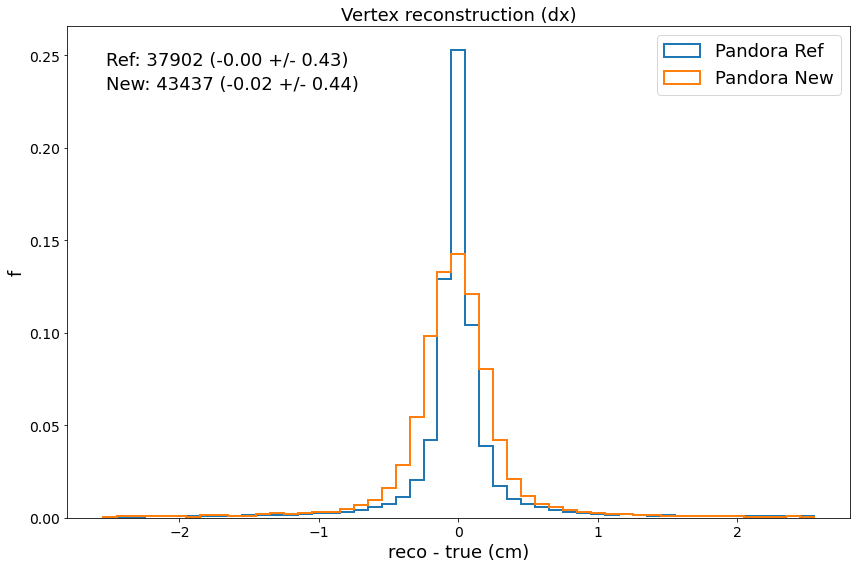

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


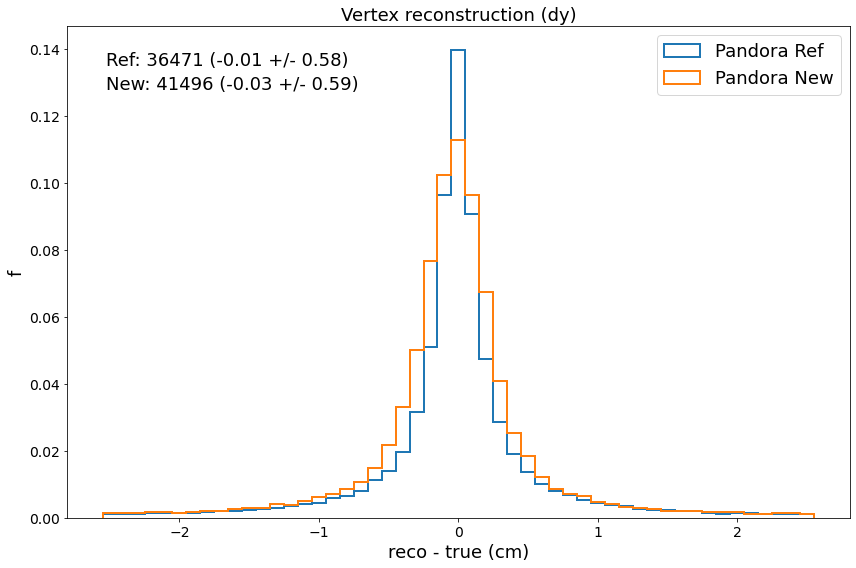

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


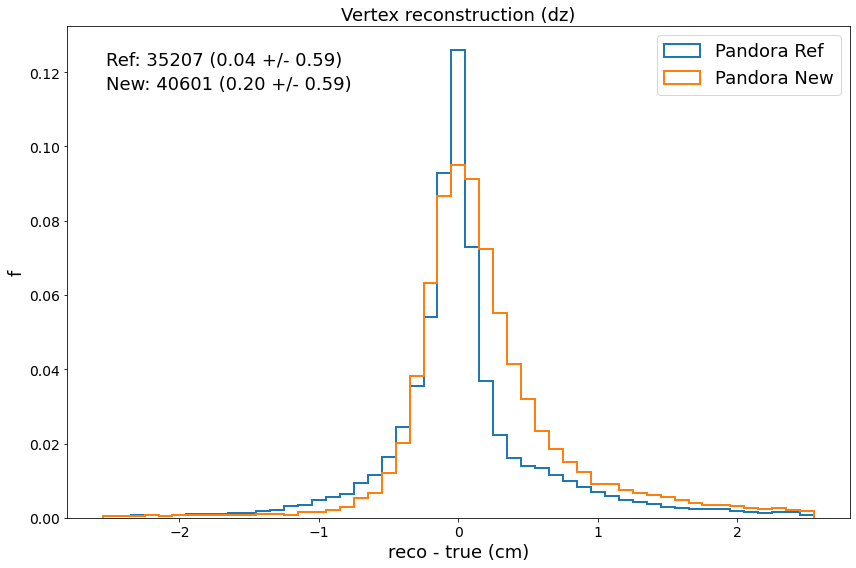

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
plot_dx(dxs_0[passing_idx_0], dxs_1[passing_idx_1], f"dxs_{run_name}", axis='x')
plot_dx(dys_0[passing_idx_0], dys_1[passing_idx_1], f"dys_{run_name}", axis='y')
plot_dx(dzs_0[passing_idx_0], dzs_1[passing_idx_1], f"dzs_{run_name}", axis='z')

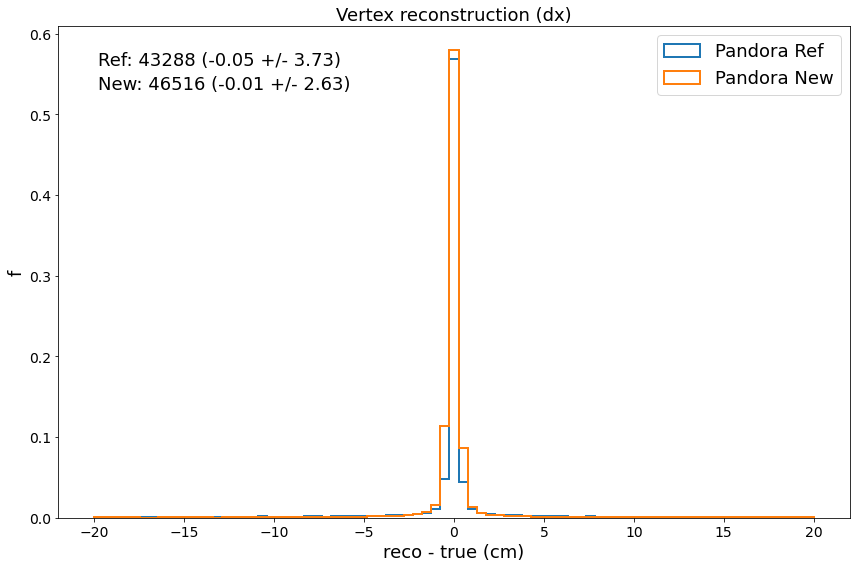

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


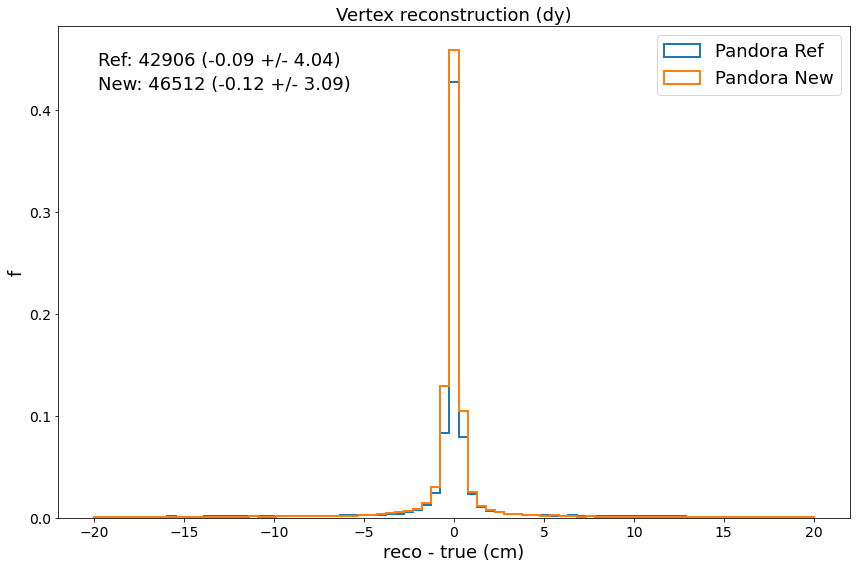

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


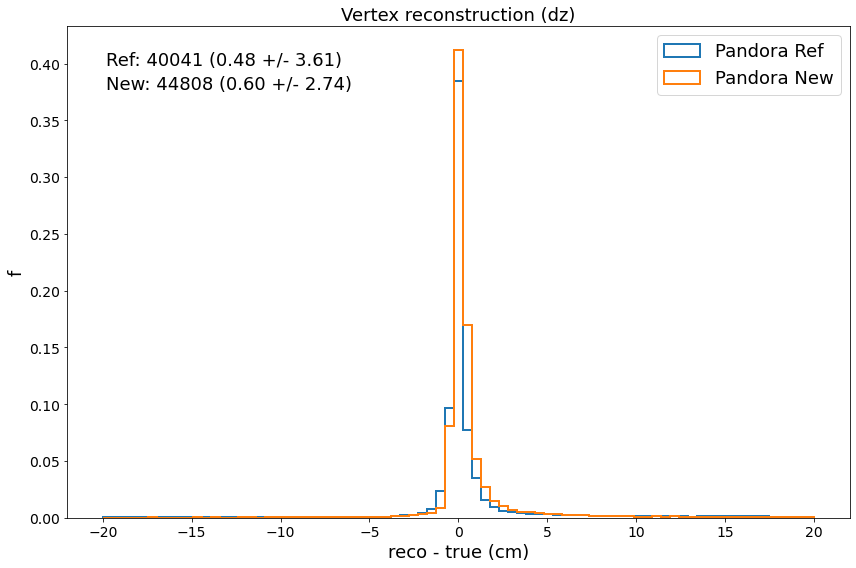

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
plot_dx(dxs_0[passing_idx_0], dxs_1[passing_idx_1], f"dxs_zoom_{run_name}", axis='x', hi=20.0, lo=-20.0, nbins=80)
plot_dx(dys_0[passing_idx_0], dys_1[passing_idx_1], f"dys_zoom_{run_name}", axis='y', hi=20.0, lo=-20.0, nbins=80)
plot_dx(dzs_0[passing_idx_0], dzs_1[passing_idx_1], f"dzs_zoom_{run_name}", axis='z', hi=20.0, lo=-20.0, nbins=80)

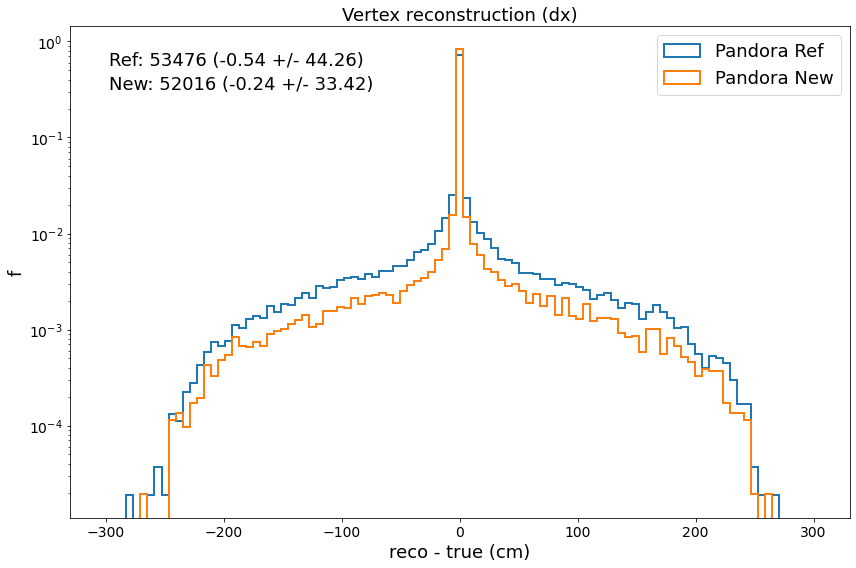

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


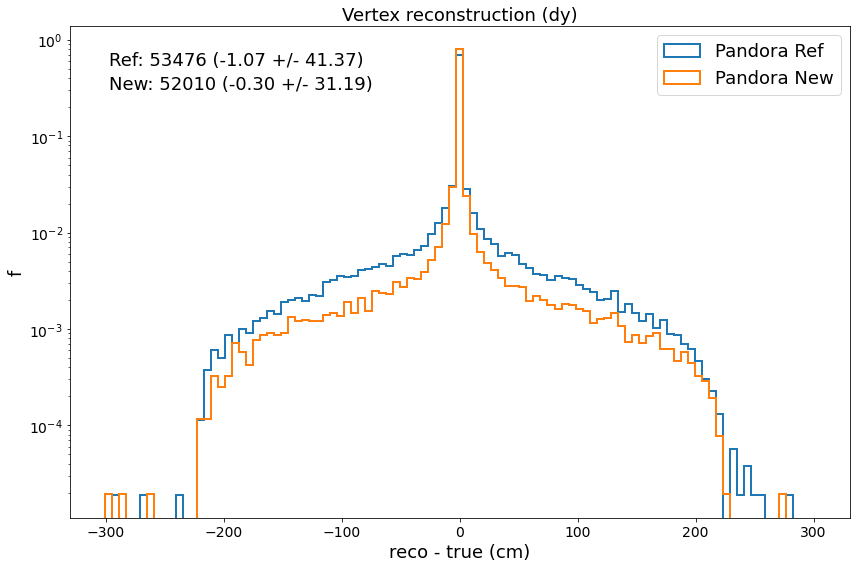

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


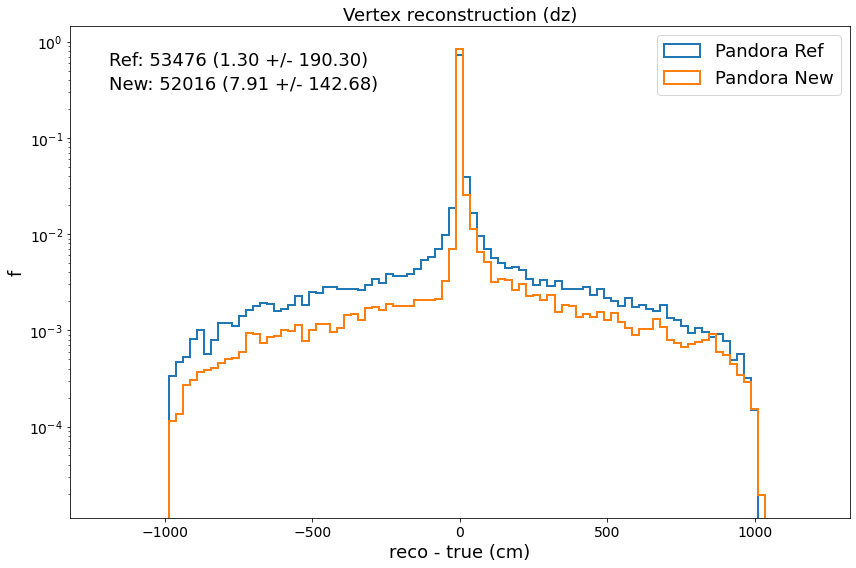

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
plot_dx(dxs_0[passing_idx_0], dxs_1[passing_idx_1], f"dxs_log_{run_name}", axis='x', log=True, hi=300.5, lo=-300.5, nbins=102)
plot_dx(dys_0[passing_idx_0], dys_1[passing_idx_1], f"dys_log_{run_name}", axis='y', log=True, hi=300.5, lo=-300.5, nbins=102)
plot_dx(dzs_0[passing_idx_0], dzs_1[passing_idx_1], f"dzs_log_{run_name}", axis='z', log=True, hi=1200.5, lo=-1200.5, nbins=102)

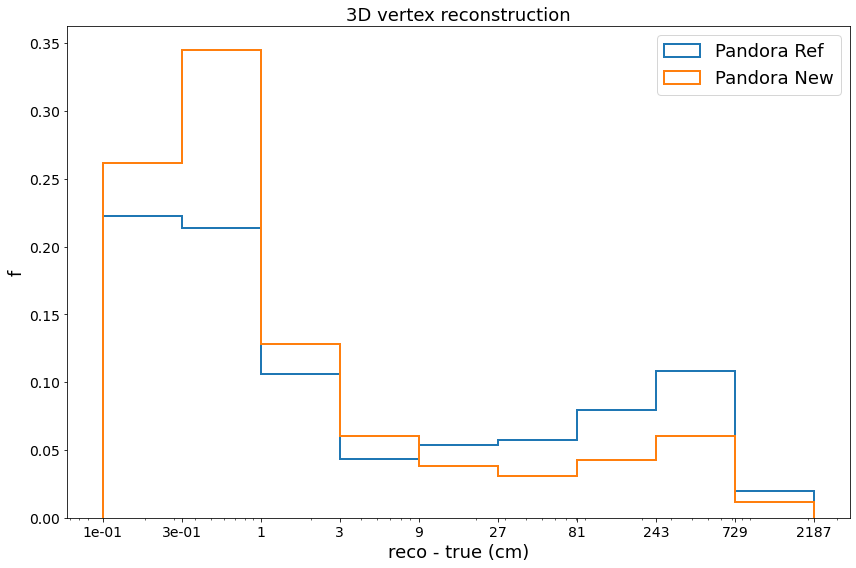

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


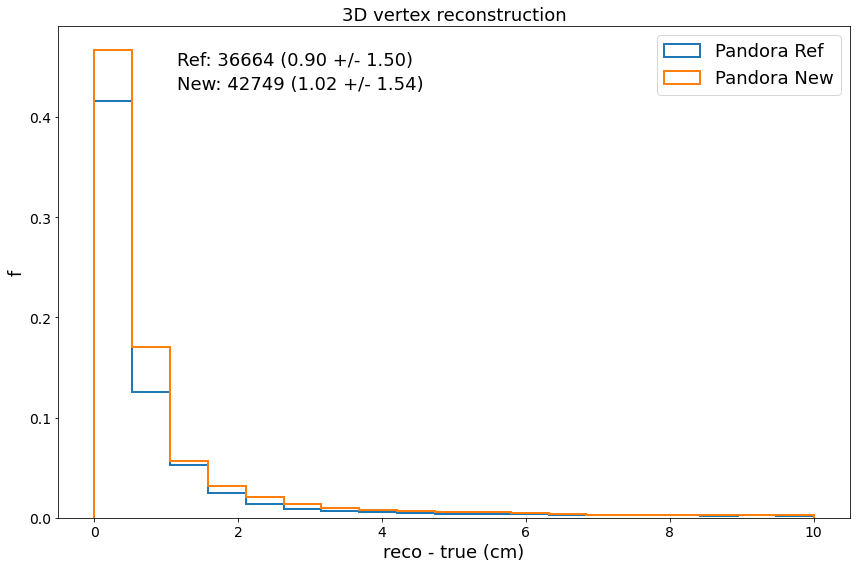

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
plot_dr(drs_0[passing_idx_0], drs_1[passing_idx_1], f"{run_name}_deltas")
plot_dr_zoom(drs_0[passing_idx_0], drs_1[passing_idx_1], f"{run_name}_deltas_zoom")

In [13]:
print(f'dr68: {np.percentile(drs_0[passing_idx_0], 68.2):.1f}')
print(f'dr90: {np.percentile(drs_0[passing_idx_0], 90.0):.1f}')
print(f'dr95: {np.percentile(drs_0[passing_idx_0], 95.45):.1f}')

dr68: 9.1
dr90: 327.2
dr95: 560.9


In [14]:
print(f'dr68: {np.percentile(drs_1[passing_idx_1], 68.2):.1f}')
print(f'dr90: {np.percentile(drs_1[passing_idx_1], 90.0):.1f}')
print(f'dr95: {np.percentile(drs_1[passing_idx_1], 95.45):.1f}')

dr68: 1.4
dr90: 135.2
dr95: 388.9


In [15]:
sorted_drs_0 = np.sort(drs_0[passing_idx_0])
print(f"% < 1cm: {100 * np.where(sorted_drs_0 < 1)[0][-1] / len(sorted_drs_0):.1f}")
print(f"% < 2cm: {100 * np.where(sorted_drs_0 < 2)[0][-1] / len(sorted_drs_0):.1f}")
print(f"% < 3cm: {100 * np.where(sorted_drs_0 < 3)[0][-1] / len(sorted_drs_0):.1f}")
print(f"% < 5cm: {100 * np.where(sorted_drs_0 < 5)[0][-1] / len(sorted_drs_0):.1f}")
print(f"% < 10cm: {100 * np.where(sorted_drs_0 < 10)[0][-1] / len(sorted_drs_0):.1f}")

% < 1cm: 53.3
% < 2cm: 61.5
% < 3cm: 63.9
% < 5cm: 66.0
% < 10cm: 68.6


In [16]:
sorted_drs_1 = np.sort(drs_1[passing_idx_1])
print(f"% < 1cm: {100 * np.where(sorted_drs_1 < 1)[0][-1] / len(sorted_drs_1):.1f}")
print(f"% < 2cm: {100 * np.where(sorted_drs_1 < 2)[0][-1] / len(sorted_drs_1):.1f}")
print(f"% < 3cm: {100 * np.where(sorted_drs_1 < 3)[0][-1] / len(sorted_drs_1):.1f}")
print(f"% < 5cm: {100 * np.where(sorted_drs_1 < 5)[0][-1] / len(sorted_drs_1):.1f}")
print(f"% < 10cm: {100 * np.where(sorted_drs_1 < 10)[0][-1] / len(sorted_drs_1):.1f}")

% < 1cm: 62.8
% < 2cm: 72.1
% < 3cm: 75.6
% < 5cm: 78.8
% < 10cm: 82.2


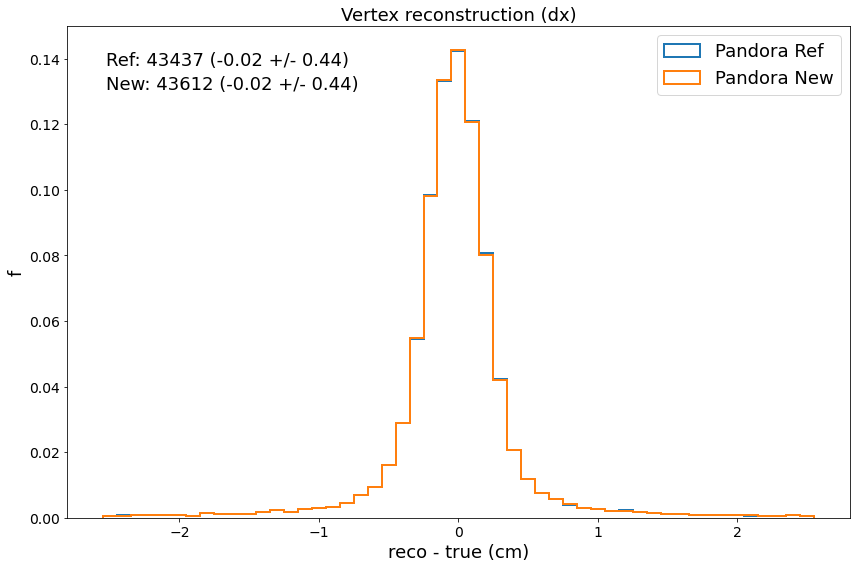

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


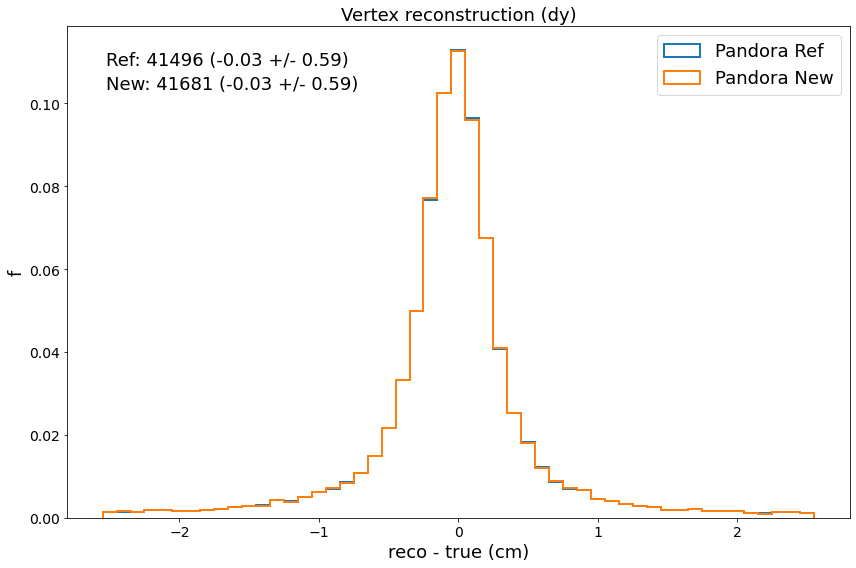

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


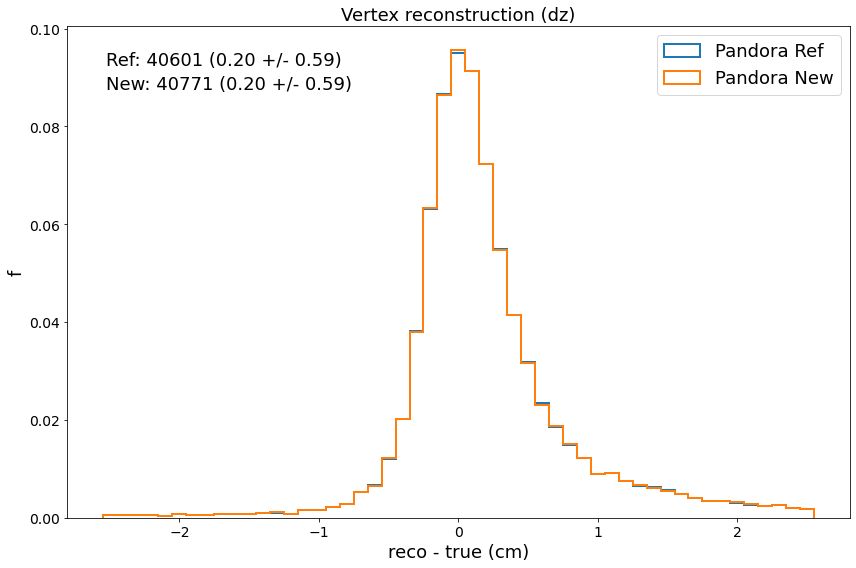

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


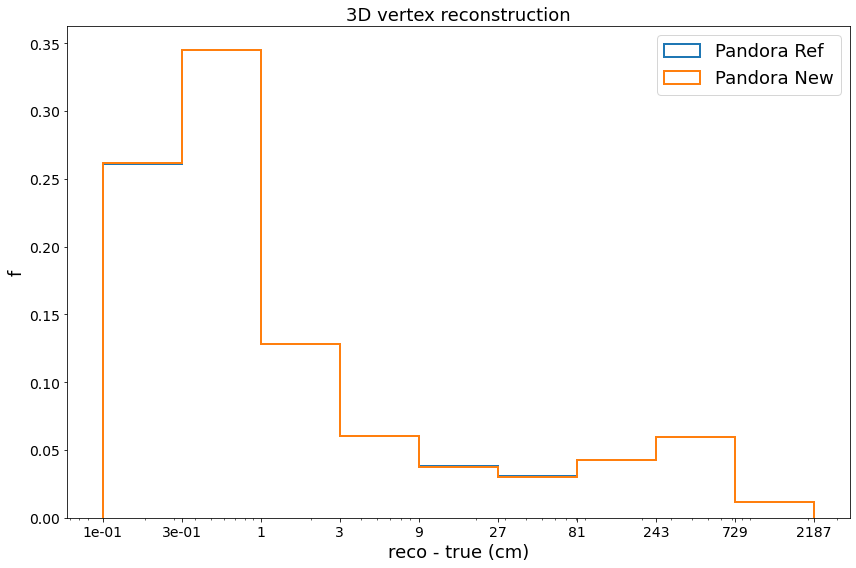

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


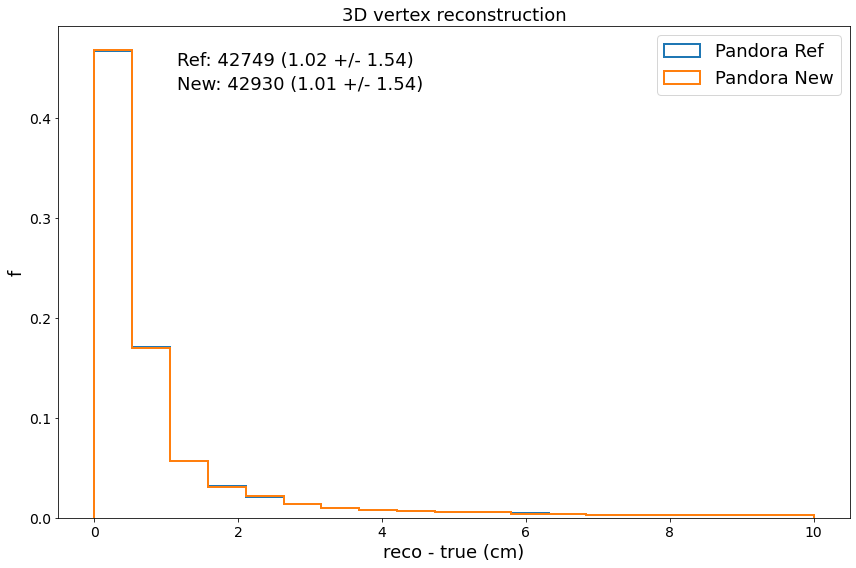

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
plot_dx(dxs_1[passing_idx_1], dxs_2[passing_idx_2], f"old_vertexing_dx", axis='x')
plot_dx(dys_1[passing_idx_1], dys_2[passing_idx_2], f"old_vertexing_dy", axis='y')
plot_dx(dzs_1[passing_idx_1], dzs_2[passing_idx_2], f"old_vertexing_dz", axis='z')

plot_dr(drs_1[passing_idx_1], drs_2[passing_idx_2], f"old_vertexing_dr")
plot_dr_zoom(drs_1[passing_idx_1], drs_2[passing_idx_2], f"old_vertexing_dr_zoom")

Len all_dz: 53142
Len notInTrueGap: 53142
dz: nan +/- nan
dz not in true gap: nan +/- nan


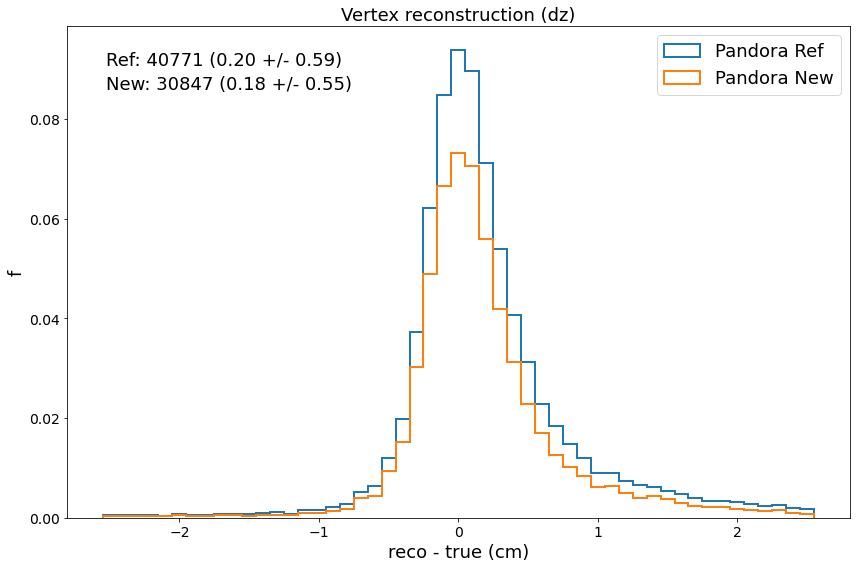

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


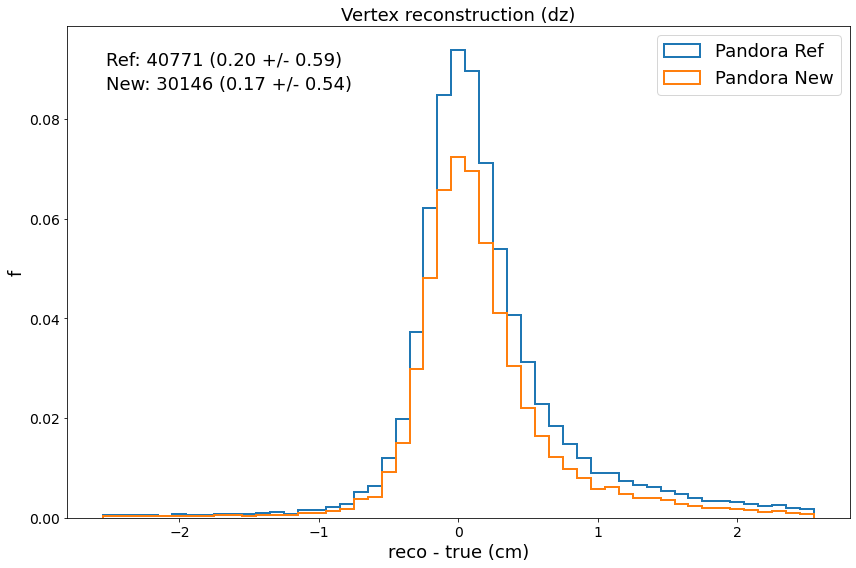

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


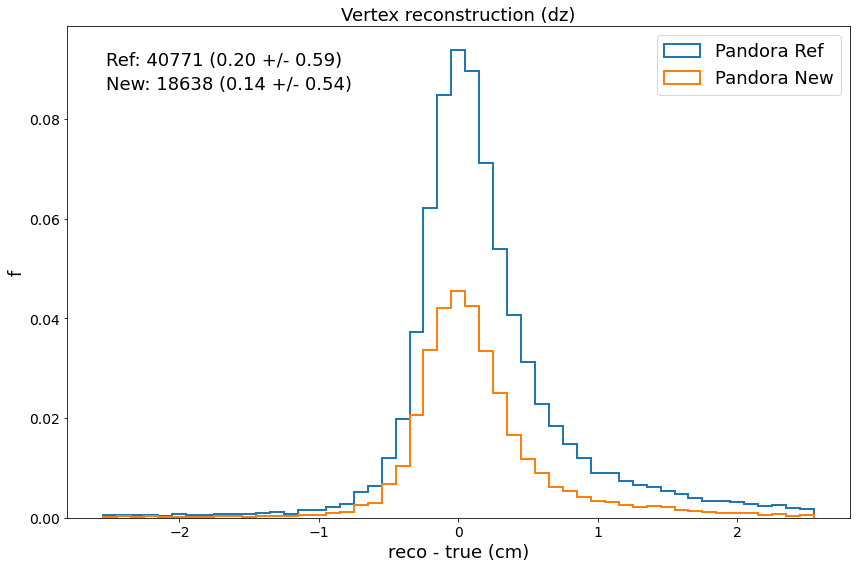

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
import pandas as pd

def load_file_extended(filename, treename):
    file = uproot.open(filename)
    tree = file[treename]
    successes = tree['success'].array(library="np")
    true_nu_energy = tree['trueNuEnergy'].array(library="np")
    drs = tree['dr'].array(library="np")
    dxs = tree['dx'].array(library="np")
    dys = tree['dy'].array(library="np")
    dzs = tree['dz'].array(library="np")
    passing_idx = np.where(successes == 1)

    gapTrueU = tree['isInGapUTrue'].array(library="np")
    gapTrueV = tree['isInGapVTrue'].array(library="np")
    gapTrueW = tree['isInGapWTrue'].array(library="np")

    gapRecoU = tree['isInGapUReco'].array(library="np")
    gapRecoV = tree['isInGapVReco'].array(library="np")
    gapRecoW = tree['isInGapWReco'].array(library="np")

    isInSliceU = tree['isInSliceU'].array(library="np")
    isInSliceV = tree['isInSliceV'].array(library="np")
    isInSliceW = tree['isInSliceW'].array(library="np")

    df = pd.DataFrame({
        'success': successes,
        'true_nu_energy': true_nu_energy,
        'dr': drs,
        'dx': dxs, 'dy': dys, 'dz': dzs,
        'gapTrueU': gapTrueU, 'gapTrueV': gapTrueV, 'gapTrueW': gapTrueW,
        'gapRecoU': gapRecoU, 'gapRecoV': gapRecoV, 'gapRecoW': gapRecoW,
        'isInSliceU': isInSliceU, 'isInSliceV': isInSliceV, 'isInSliceW': isInSliceW,
    })

    file.close()
    return df

df_test = load_file_extended('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_dl_all_fix_with_old.root', 'vertices')
# df_ref = load_file_extended('/Users/rcross/Downloads/vertexing/metrics/vertex_ub_svm_new_metrics.root', 'vertices')

all_dz = df_test.where(df_test.success == 1).dz

high_comp_dz = all_dz.where((df_test.isInSliceU == 1) & (df_test.isInSliceV == 1) & (df_test.isInSliceW == 1))
